# Convergencia Tipo X

In [1]:
import numpy as np
import pandas as pd

import sys, os

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
from pyfrechet.metric_spaces import MetricData, LogCholesky, spd_to_log_chol, log_chol_to_spd
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from sklearn.model_selection import train_test_split
from pyfrechet.metric_spaces import MetricData, Wasserstein1D
from pyfrechet.metric_spaces import wasserstein_1d as ws
from scipy import stats 
from typing import Union


INFO: Using numpy backend


## Functions

In [2]:
GRID = np.linspace(0.01, 0.99, 100)
STD_NORMAL_Q = stats.norm.ppf(GRID)


def sample_linear_transport(x, sig=1, gam=0.5):
    gam = np.random.gamma(0.5, 0.5)
    sig = np.random.exponential(0.5)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data(N):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.random.uniform(0,1, N)
    y = np.array([ sample_linear_transport(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

In [3]:
# Obtain coverage results dataframe from the results files
def coverage_results() -> pd.DataFrame:
    coverage_df=pd.DataFrame(columns=['sample_index', 'y_train_data', 'train_predictions', 'OOB_quantile', 'OOB_errors', 'forest'])
    for file in os.listdir(os.path.join(os.getcwd(), 'wass_results')):
        if file.endswith('.npy'):
            infile=open(os.path.join(os.getcwd(), 'wass_results/'+file), 'rb')
            result=np.load(infile, allow_pickle=True).item()
            infile.close()

            coverage_df=pd.concat([coverage_df, 
                                    pd.DataFrame({  'sample_index': int(file.split('_')[1][4:]),
                                                    'y_train_data': [result['y_train_data']],
                                                    'train_predictions': [result['train_predictions']],
                                                    'forest': [result['forest']],
                                                }, index=pd.RangeIndex(0,1))],
                                    ignore_index=True)
        
    coverage_df['sample_index'] = coverage_df['sample_index'].astype('category')

    return coverage_df

coverage_df = coverage_results()

#print(coverage_df.info())

In [4]:
coverage_df['OOB_errors'] = coverage_df.apply(lambda row: row['forest'].oob_errors(), axis=1)

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [9]:
sign_level = np.array([0.01, 0.05, 0.1])
coverage_df['OOB_quantile'] = coverage_df.apply(lambda row: np.percentile(row['OOB_errors'], (1 - sign_level) * 100), axis=1)

In [10]:
coverage_df['II_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df))]
M = Wasserstein1D()
MC = 500

np.random.seed(1000)

#Calculate coverage for every dataset L_n (Type IV):
for i, ln in coverage_df.iterrows():
        #Generate observations to estimate the probability
    new_t, new_y = gen_data(MC).values()
    new_t = MetricData(M,new_t.reshape(-1,1))
    new_y = MetricData(M, np.array(new_y))

    new_pred = ln['forest'].predict(new_t)

    coverage_df.at[i, 'II_coverage'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

# Boxplots

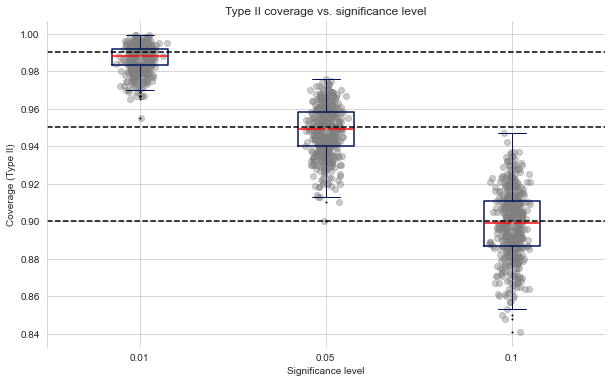

In [16]:
##### Set style options here ####
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

first_elements = [x[0] for x in coverage_df['II_coverage'].values]
second_elements = [x[1] for x in coverage_df['II_coverage'].values]
third_elements = [x[2] for x in coverage_df['II_coverage'].values]
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
plt.figure(facecolor="white", figsize=(10, 6))
boxplot_data = pd.DataFrame({
    '0_01': first_elements,
    '0_05': second_elements,
    '0_1': third_elements
})

plt.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=True) 
vals, names, xs = [],[],[]
for i, col in enumerate(boxplot_data.columns):
    vals.append(boxplot_data[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
for x, val, in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4, color = 'gray')
sns.despine(bottom=True) # removes right and top axis lines

#plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)
plt.title(f'Type II coverage vs. significance level')
plt.xlabel('Significance level')
plt.ylabel('Coverage (Type II)')
plt.axhline(y= 1 - 0.01, color='black', linestyle='dashed')
plt.axhline(y= 1 - 0.05, color='black', linestyle='dashed')
plt.axhline(y= 1 - 0.1, color='black', linestyle='dashed')
plt.style.use('grayscale')
plt.show()

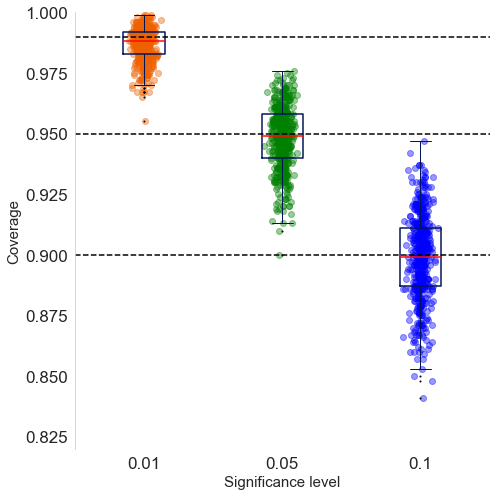

In [219]:
# Plot coverages vs. training sample size

##### Set style options here #####

boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

first_elements = [x[0] for x in coverage_df['II_coverage'].values]
second_elements = [x[1] for x in coverage_df['II_coverage'].values]
third_elements = [x[2] for x in coverage_df['II_coverage'].values]

boxplot_data = pd.DataFrame({
    '0_01': first_elements,
    '0_05': second_elements,
    '0_1': third_elements
})
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
fig = plt.figure(facecolor="white", figsize=(7, 7))
ax = fig.add_subplot(111)
ax.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

vals, names, xs = [],[],[]
for i, col in enumerate(boxplot_data.columns):
    vals.append(boxplot_data[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
palette = ['#ee6100', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    ax.scatter(x, val, alpha=0.4, color=c)
sns.despine(bottom=True) # removes right and top axis lines

#plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)

ax.set_xlabel('Significance level', fontsize=15)
ax.set_ylabel('Coverage', fontsize=15)
ax.set_ylim(0.82, 1)
# ax.set_yticks(np.linspace(0.825, 1, 8, endpoint=True))
ax.tick_params(labelsize=17)
ax.axhline(y= 1 - 0.01, color='black', linestyle='dashed')
ax.axhline(y= 1 - 0.05, color='black', linestyle='dashed')
ax.axhline(y= 1 - 0.1, color='black', linestyle='dashed')
ax.grid(False)
fig.tight_layout()
fig.savefig('type_II_coverage.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
plt.show()

# Type IV

In [27]:
coverage_df['IV_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df))]
coverage_df['IV_coverage_05'] = [[0, 0, 0] for _ in range(len(coverage_df))]
coverage_df['IV_coverage_1'] = [[0, 0, 0] for _ in range(len(coverage_df))]


In [132]:
def sample_linear_transport_IV(x, sig=1, gam=0.5):
    gam = np.random.gamma(0.5, 0.5)
    sig = np.random.exponential(0.5)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data_IV(N, x0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([sample_linear_transport_IV(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

In [47]:
# Obtain Type IV coverages for affine invariant distance
np.random.seed(1000)
M = Wasserstein1D()
MC = 500

for i, ln in coverage_df.iterrows():
        #Generate observations to estimate the probability
    new_t, new_y = gen_data_IV(N = MC, x0 = 0).values()
    new_y = MetricData(M, np.array(new_y))

    new_pred = ln['forest'].predict(new_t.reshape(-1,1))

    coverage_df.at[i, 'IV_coverage'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

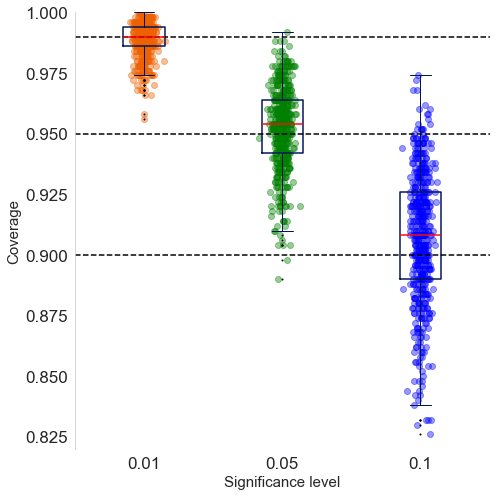

In [223]:
# Plot coverages vs. training sample size

##### Set style options here #####

boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

first_elements = [x[0] for x in coverage_df['IV_coverage'].values]
second_elements = [x[1] for x in coverage_df['IV_coverage'].values]
third_elements = [x[2] for x in coverage_df['IV_coverage'].values]

boxplot_data = pd.DataFrame({
    '0_01': first_elements,
    '0_05': second_elements,
    '0_1': third_elements
})
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
fig = plt.figure(facecolor="white", figsize=(7, 7))
ax = fig.add_subplot(111)
ax.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

vals, names, xs = [],[],[]
for i, col in enumerate(boxplot_data.columns):
    vals.append(boxplot_data[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
palette = ['#ee6100', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    ax.scatter(x, val, alpha=0.4, color=c)
sns.despine(bottom=True) # removes right and top axis lines

#plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)

ax.set_xlabel('Significance level', fontsize=15)
ax.set_ylabel('Coverage', fontsize=15)
ax.set_ylim(0.82, 1)
ax.tick_params(labelsize=17)
ax.axhline(y= 1 - 0.01, color='black', linestyle='dashed')
ax.axhline(y= 1 - 0.05, color='black', linestyle='dashed')
ax.axhline(y= 1 - 0.1, color='black', linestyle='dashed')
ax.grid(False)
fig.tight_layout()
fig.savefig('type_IV_coverage.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
plt.show()

$x=0.5$

In [49]:
# Obtain Type IV coverages for affine invariant distance
np.random.seed(1000)
M = Wasserstein1D()
MC = 500

for i, ln in coverage_df.iterrows():
    #Generate observations to estimate the probability
    new_t, new_y = gen_data_IV(N = MC, x0 = 0.5).values()
    new_y = MetricData(M, np.array(new_y))

    new_pred = ln['forest'].predict(new_t.reshape(-1,1))

    coverage_df.at[i, 'IV_coverage_05'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

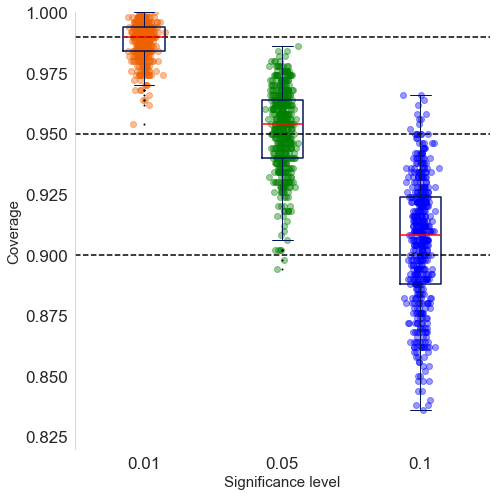

In [244]:
##### Set style options here #####

boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

first_elements = [x[0] for x in coverage_df['IV_coverage_05'].values]
second_elements = [x[1] for x in coverage_df['IV_coverage_05'].values]
third_elements = [x[2] for x in coverage_df['IV_coverage_05'].values]

boxplot_data = pd.DataFrame({
    '0_01': first_elements,
    '0_05': second_elements,
    '0_1': third_elements
})
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
fig = plt.figure(facecolor="white", figsize=(7, 7))
ax = fig.add_subplot(111)
ax.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 

vals, names, xs = [],[],[]
for i, col in enumerate(boxplot_data.columns):
    vals.append(boxplot_data[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
palette = ['#ee6100', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    ax.scatter(x, val, alpha=0.4, color=c)
sns.despine(bottom=True) # removes right and top axis lines

#plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)

ax.set_xlabel('Significance level', fontsize=15)
ax.set_ylabel('Coverage', fontsize=15)
ax.set_ylim(0.82, 1)
ax.tick_params(labelsize=17)
ax.axhline(y= 1 - 0.01, color='black', linestyle='dashed')
ax.axhline(y= 1 - 0.05, color='black', linestyle='dashed')
ax.axhline(y= 1 - 0.1, color='black', linestyle='dashed')
ax.grid(False)
fig.tight_layout()
fig.savefig('type_IV_coverage_05.pdf', bbox_inches = 'tight', format='pdf', transparent=True)
plt.show()

## x = 1

In [51]:
# Obtain Type IV coverages for affine invariant distance
np.random.seed(1000)
M = Wasserstein1D()
MC = 500

for i, ln in coverage_df.iterrows():
    #Generate observations to estimate the probability
    new_t, new_y = gen_data_IV(N = MC, x0 = 1).values()
    new_y = MetricData(M, np.array(new_y))

    new_pred = ln['forest'].predict(new_t.reshape(-1,1))

    coverage_df.at[i, 'IV_coverage_1'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

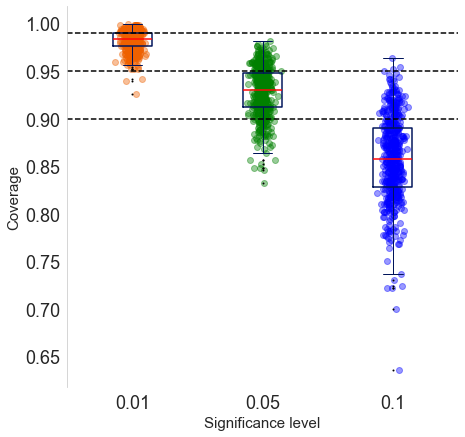

In [176]:
# Plot coverages vs. training sample size

##### Set style options here #####

sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

first_elements = [x[0] for x in coverage_df['IV_coverage_1'].values]
second_elements = [x[1] for x in coverage_df['IV_coverage_1'].values]
third_elements = [x[2] for x in coverage_df['IV_coverage_1'].values]

boxplot_data = pd.DataFrame({
    '0_01': first_elements,
    '0_05': second_elements,
    '0_1': third_elements
})
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
plt.figure(facecolor="white", figsize=(7,7))
plt.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 
vals, names, xs = [],[],[]
for i, col in enumerate(boxplot_data.columns):
    vals.append(boxplot_data[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
palette = ['#ee6100', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)
sns.despine(bottom=True) # removes right and top axis lines

#plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)
plt.xlabel('Significance level')
plt.ylabel('Coverage')
plt.axhline(y= 1 - 0.01, color='black', linestyle='dashed')
plt.axhline(y= 1 - 0.05, color='black', linestyle='dashed')
plt.axhline(y= 1 - 0.1, color='black', linestyle='dashed')
plt.xlabel('Significance level', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.style.use('grayscale')
plt.grid(False)
plt.savefig('type_IV_coverage_x_1.pdf', format='pdf', transparent=True)
plt.show()

In [44]:
MC = 500

zeros_init = np.zeros(3)
diccionario = {'0': zeros_init, '05': zeros_init, '1': zeros_init}

# Obtain 25 estimations of Type I coverage error for each distance and N, to calculate the mean of the estimations and the sample variance
M = Wasserstein1D()

for x in [0, 0.5, 1]:
    cov = np.zeros(3)
    yesno = np.zeros(3)
    # Randomly select rows from the dataframe
    new_ts, new_ys = gen_data_IV(MC, x0=x).values()
    lns = coverage_df.sample(n=MC, replace = False)
    i = 0
    for _, ln in lns.iterrows():
        # Generate one random point to test if it belongs to the prediction ball
        new_t = new_ts[i]
        # Predict the new observation
        new_pred = ln['forest'].predict(new_t.reshape(-1, 1))
        new_y = new_ys[i]
        yesno = np.vstack((yesno, M.d(new_pred, new_y) <= ln['OOB_quantile']))
        i += 1
    cov = yesno[1:, :].sum(axis=0) / MC
    diccionario[f'x_{x}'] = cov

diccionario

{'0': array([0., 0., 0.]),
 '05': array([0., 0., 0.]),
 '1': array([0., 0., 0.]),
 'x_0': array([0.998, 0.956, 0.928]),
 'x_0.5': array([0.992, 0.958, 0.916]),
 'x_1': array([0.988, 0.916, 0.864])}

In [45]:
MC = 500

# Obtain 1 estimation of Type I coverage error for each distance and N, to calculate the mean of the estimations and the sample variance
M = Wasserstein1D()

cov = np.zeros(3)
yesno = np.zeros(3)
# Randomly select rows from the dataframe
new_ts, new_ys = gen_data(MC).values()
lns = coverage_df.sample(n=MC, replace = False)
i = 0
for _, ln in lns.iterrows():
    # Generate one random point to test if it belongs to the prediction ball
    new_t = new_ts[i]
    # Predict the new observation
    new_pred = ln['forest'].predict(new_t.reshape(-1, 1))
    new_y = new_ys[i]
    yesno = np.vstack((yesno, M.d(new_pred, new_y) <= ln['OOB_quantile']))
    i += 1
cov = yesno[1:, :].sum(axis=0) / MC

cov

array([0.992, 0.946, 0.91 ])

In [55]:
def sample_linear_transport2_IV(x, sig=1, gam=0.5):
    gam = np.random.uniform(0,4)
    sig = np.random.uniform(0,4)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data2_IV(N, x0 = 0):
    # We know the values of Q in a GRID, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport2_IV(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

def sample_linear_transport3_IV(x, sig=1, gam=0.5):
    gam = np.random.uniform(0,4)
    sig = np.random.uniform(0,4)
    Q0 = - gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data3_IV(N, x0 = 0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport3_IV(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

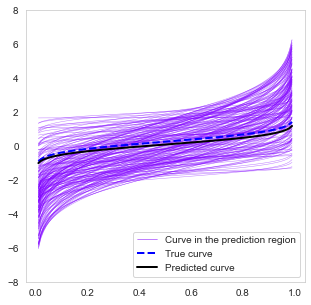

In [237]:
np.random.seed(7)

MC = 100
x0 = 0
x, y_MC2 = gen_data2_IV(100*MC, x0 = x0).values()
x, y_MC3 = gen_data3_IV(100*MC, x0 = x0).values()
pred = ln['forest'].predict(x[0].reshape(-1,1))

# Get the rainbow colormap
cmap = plt.cm.rainbow

y = 1/4 - np.log(1 + x0) + (1/2 + x0**2) * STD_NORMAL_Q

fig, ax = plt.subplots(1, 1, figsize = (5, 5), facecolor="white")
ax.set_ylim([-8, 8])
i = 0
cont = 0
while cont <1:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.05, linewidth=0.5, color = cmap(0.0), label = 'Curve in the prediction region')
        cont += 1
        i +=  1
    else: 
        i += 1

i  = 0
mc = 0      
# First plot
while mc < MC:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.0))
        mc += 1
    i += 1

i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC3[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC3[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.0))
        mc += 1
    i += 1
    

ax.plot(GRID, y.squeeze(),  color='blue', linestyle = 'dashed', linewidth=2, label='True curve')
ax.plot(GRID, pred, color='black', linewidth=2, label='Predicted curve')

leg = ax.legend(loc = 4)
for line in leg.get_lines():
    line.set_alpha(1)
leg
ax.grid(False)
plt.savefig('prediction_region_x_0_alpha_01.png', bbox_inches='tight', format='png', dpi = 600, transparent=True)

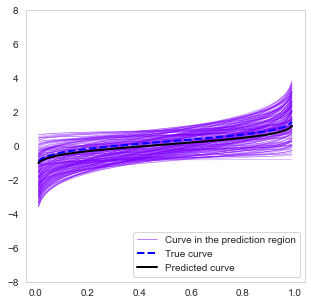

In [238]:
np.random.seed(7)

x0 = 0
pred = ln['forest'].predict(np.array([x0]).reshape(-1,1))

y = 1/4 - np.log(1 + x0) + (1/2 + x0**2) * STD_NORMAL_Q

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")  # Square format
ax.set_ylim([-8, 8])

i = 0
cont = 0
while cont <1:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.0), label = 'Curve in the prediction region')
        cont += 1
        i +=  1
    else: 
        i += 1
        
i  = 0
mc = 0      
# First plot
while mc < MC:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.0))
        mc += 1
    i += 1

i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC3[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC3[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.0))
        mc += 1
    i += 1

ax.plot(GRID, y.squeeze(), color='blue', linewidth=2, linestyle = 'dashed', label='True curve')
ax.plot(GRID, pred, color='black', linewidth=2, label='Predicted curve')
leg = ax.legend(loc = 4)
ax.grid(False)
for line in leg.get_lines():
    line.set_alpha(1)
leg
plt.savefig('prediction_region_x_0_alpha_1.png', format='png', dpi=600, bbox_inches='tight', transparent=True)

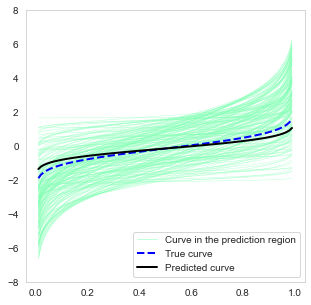

In [239]:
np.random.seed(7)
x0 = 0.5

pred = ln['forest'].predict(np.array([x0]).reshape(-1,1))
y = 1/4 - np.log(1 + x0) + (1/2 + x0**2) * STD_NORMAL_Q

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")
ax.set_ylim([-8, 8])

i = 0
cont = 0
while cont <1:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.05, linewidth=0.5, color = cmap(0.5), label = 'Curve in the prediction region')
        cont += 1
        i +=  1
    else: 
        i += 1
        
i  = 0
mc = 0      
# First plot
while mc < MC:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.5))
        mc += 1
    i += 1

i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC3[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC3[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.5))
        mc += 1
    i += 1

ax.plot(GRID, y.squeeze(), color='blue', linewidth=2, linestyle = 'dashed', label='True curve')
ax.plot(GRID, pred, color='black', linewidth=2, label='Predicted curve')
leg = ax.legend(loc = 4)
ax.grid(False)
for line in leg.get_lines():
    line.set_alpha(1)
leg
plt.savefig('prediction_region_x_05_alpha_01.png', format='png', dpi = 600, bbox_inches='tight', transparent=True)

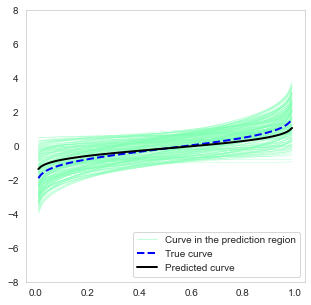

In [240]:
np.random.seed(7)

x0 = 0.5
pred = ln['forest'].predict(np.array([x0]).reshape(-1,1))
y = 1/4 - np.log(1 + x0) + (1/2 + x0**2) * STD_NORMAL_Q

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")
ax.set_ylim([-8, 8])

i = 0
cont = 0
while cont <1:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.5), label = 'Curve in the prediction region')
        cont += 1
        i +=  1
    else: 
        i += 1
        
i  = 0
mc = 0      
# First plot
while mc < MC:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.5))
        mc += 1
    i += 1

i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC3[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC3[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(0.5))
        mc += 1
    i += 1

ax.plot(GRID, y.squeeze(), color='blue', linewidth=2, linestyle = 'dashed', label='True curve')
ax.plot(GRID, pred, color='black', linewidth=2, label='Predicted curve')
leg = ax.legend(loc = 4)
ax.grid(False)
for line in leg.get_lines():
    line.set_alpha(1)
leg
plt.savefig('prediction_region_x_05_alpha_1.png', format='png', dpi = 600, bbox_inches='tight',transparent=True)

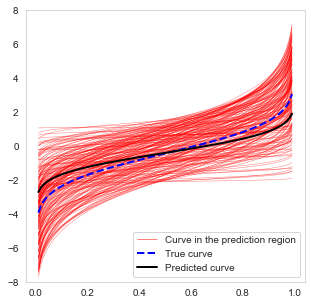

In [241]:
np.random.seed(3)

x0 = 1
pred = ln['forest'].predict(np.array([x0]).reshape(-1,1))
y = 1/4 - np.log(1 + x0) + (1/2 + x0**2) * STD_NORMAL_Q

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")
ax.set_ylim([-8, 8])

i = 0
cont = 0
while cont <1:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(1.0), label = 'Curve in the prediction region')
        cont += 1
        i +=  1
    else: 
        i += 1
        
i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(1.0))
        mc += 1
    i += 1

i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC3[i,:]) <= ln['OOB_quantile'][0]:
        ax.plot(GRID, y_MC3[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(1.0))
        mc += 1
    i += 1

ax.plot(GRID, y.squeeze(), color='blue', linewidth=2, linestyle = 'dashed', label='True curve')
ax.plot(GRID, pred, color='black', linewidth=2,  label='Predicted curve')
leg = ax.legend(loc = 4)
ax.grid(False)
for line in leg.get_lines():
    line.set_alpha(1)
leg
plt.savefig('prediction_region_x_1_alpha_01.png', format='png', dpi = 600, bbox_inches='tight',transparent=True)

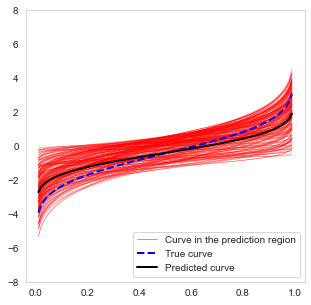

In [242]:
np.random.seed(7)

x0 = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor="white")
ax.set_ylim([-8, 8])

pred = ln['forest'].predict(np.array([x0]).reshape(-1,1))

y = 1/4 - np.log(1 + x0) + (1/2 + x0**2) * STD_NORMAL_Q

i = 0
cont = 0
while cont <1:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(1.0), label = 'Curve in the prediction region')
        cont += 1
        i +=  1
    else: 
        i += 1

i = 0
mc = 0    
while mc < MC:
    if M.d(pred, y_MC2[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC2[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(1.0))
        mc += 1
    i += 1

i = 0
mc = 0
while mc < MC:
    if M.d(pred, y_MC3[i,:]) <= ln['OOB_quantile'][2]:
        ax.plot(GRID, y_MC3[i,:].squeeze(), alpha=0.5, linewidth=0.5, color = cmap(1.0))
        mc += 1
    i += 1
ax.plot(GRID, y.squeeze(), color='blue', linestyle = 'dashed', linewidth=2, label='True curve')
ax.plot(GRID, pred, color='black', linewidth=2, label='Predicted curve')
leg = ax.legend(loc = 4)
ax.grid(False)
for line in leg.get_lines():
    line.set_alpha(1)
leg

plt.savefig('prediction_region_x_1_alpha_1.png', format='png', dpi = 600, bbox_inches='tight', transparent=True)
plt.show()

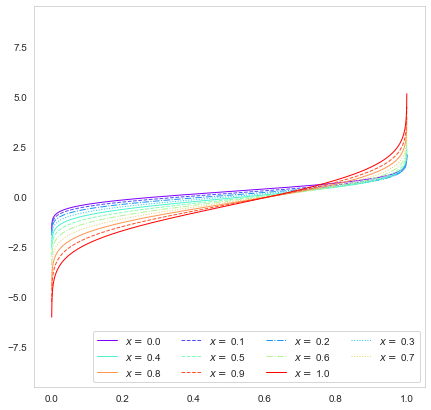

In [236]:
np.random.seed(1000)
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])
new_grid = np.linspace(0, 1, 10000)
new_quantile = stats.norm.ppf(new_grid)

fig = plt.figure(facecolor="white", figsize=(7, 7))
ax = fig.add_subplot(111)

# Get the rainbow colormap
cmap = plt.cm.rainbow

# Define line styles
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

for i, x in enumerate(np.linspace(0, 1, 11, endpoint=True)):
    Q1 = 1/4 - np.log(1 + x) + (1/2 + x**2) * new_quantile
    
    # Use the rainbow colormap to get a color based on the index
    color = cmap(i / 10)  # Normalize the index to get a color in the rainbow range
    ax.plot(new_grid, Q1, linestyle=line_styles[i % len(line_styles)], linewidth=1, label=np.round(x, 2), color=color)

# Adjust legend
h, l = ax.get_legend_handles_labels()
ax.legend(reorder(h, 4), [f'$x =$ {label}' for label in reorder(l, 4)], ncol=4, loc=4)
ax.grid(False)
ax.set_ylim(-9.5, 9.5)
plt.savefig('m(x).pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

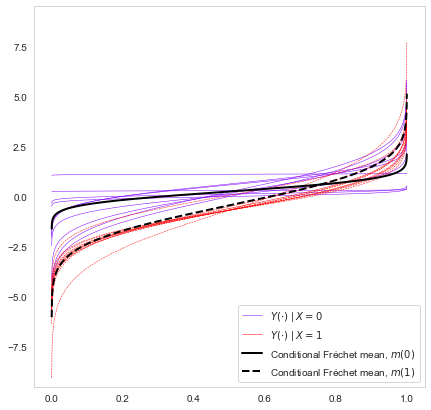

In [235]:
GRID2 = np.linspace(0, 1, 10000)
STD_NORMAL_Q2 = stats.norm.ppf(GRID2)

def sample_linear_transport5(x, sig=1, gam=0.5):
    gam = np.random.gamma(0.5, 0.5)
    sig = np.random.exponential(0.5)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q2
    return Q0 

def gen_data5(N, x0 = 0):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(x0, N)
    y = np.array([ sample_linear_transport5(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

np.random.seed(1000)
fig = plt.figure(facecolor="white", figsize=(7, 7))
ax = fig.add_subplot(111)
# Get two distinct colors from the rainbow colormap
cmap = plt.cm.rainbow
color_0 = cmap(0.0)  # Color for X=0
color_1 = cmap(1.0)  # Color for X=1

# Plot 10 realizations of Y(t)|X=0 using color_0
for _ in range(9):
    ax.plot(GRID2, gen_data5(1, x0=0)['y'][0].squeeze(), linewidth=0.5, alpha=1, color=color_0)
ax.plot(GRID2, gen_data5(1, x0=0)['y'][0].squeeze(), linewidth=0.5, alpha=1, color=color_0, label=r'$Y(\cdot) \mid X=0$')

# Plot 10 realizations of Y(t)|X=1 using color_1
for _ in range(10):
    ax.plot(GRID2, gen_data5(1, x0=1)['y'][0].squeeze(), linewidth=0.5, linestyle='--', alpha=1, color=color_1)
ax.plot(GRID2, gen_data5(1, x0=1)['y'][0].squeeze(), linewidth=0.5, alpha=1, color=color_1, label=r'$Y(\cdot) \mid X=1$')

# Plot the Fréchet mean curve for X=0
Q0 = 1/4 - np.log(1 + 0) + (1/2 + 0**2) * STD_NORMAL_Q2
ax.plot(GRID2, Q0, color='black', linewidth=2, label=r'Conditional Fréchet mean, $m(0)$')

# Plot the theoretical curve for X=1
Q1 = 1/4 - np.log(1 + 1) + (1/2 + 1**2) * STD_NORMAL_Q2
ax.plot(GRID2, Q1, color='black', linewidth=2, linestyle='--', label=r'Conditioanl Fréchet mean, $m(1)$')
ax.set_ylim(-9.5, 9.5)
ax.legend(loc = 4)
ax.grid(False)
plt.savefig('Y(t)X.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()